In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import MDAnalysis as mda
import pydiffusion
from MDAnalysisTests import make_Universe
from pydiffusion import plotting

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysisTests/__init__.py:109: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/max/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/max/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/max/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/max/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.I

This is example notebook should teach you how to start using pydiffusion to analyze rotation diffusion of molecules from simulations.

# Generate Test Trajectory

First we have to generate test data that we can analyse. For simplicity the test trajectory will only include rotations. Such a test can be generated using the rotational Brownian dynamics algorithm included in pydiffusion.

In [2]:
D = [20, 10, 5]
dt = 5e-3  # picoseconds
T = 500  # nanoseconds
niter = int(T / dt)
trj = pydiffusion.quaternionsimulation.run(D, niter, dt)

`quaternionsimulation` will return a list of quaternions that represent the orientations of our currently unspecified rigid object. We need to turn the quaternions into rotation matrices.

In [3]:
R = [pydiffusion.quaternionsimulation.quaternion_to_matrix(q) for q in trj]

This *trajectory* of rotation matrices can now be used to construct a example trajectory. As rigid body we will now use a Tetrahedron centered at the origin.

In [4]:
u = make_Universe(('altLocs', 'masses', 'occupancies', 'tempfactors',
                   'resnames', 'names', 'resids', 'resnums', 'segids', ),
                  trajectory=True)
# update default given by make_Universe with sensible values
u.atoms.residues.resnames = 'ALA'
u.atoms.segments.segids = 'A'
u.atoms.names = 'CA'
u.atoms.altLocs = ''
a = 5  # edge-length
tetrahedron = u.atoms[:4]
tetrahedron[0].position = [0, 0, 0]
tetrahedron[1].position = [a, 0, 0]
tetrahedron[2].position = [a/2., np.sqrt(3)/2.*a, 0]
tetrahedron[3].position = tetrahedron[:3].centroid() + [0, 0, np.sqrt(2/3.)*a]
tetrahedron.translate(- tetrahedron.centroid())
tetrahedron.write('tetrahedron.pdb')
tetrahedron = mda.Universe('tetrahedron.pdb')

/home/max/anaconda3/lib/python3.6/site-packages/MDAnalysis/coordinates/PDB.py:892: UserWarning: Found no information for attr: 'icodes' Using default value of ' '
  "".format(attrname, default))


In [5]:
pos = tetrahedron.atoms.positions.copy()
with mda.Writer('tetrahedron.dcd', n_atoms=4) as w:
    for r in R:
        tetrahedron.atoms.positions = pos.copy()
        tetrahedron.atoms.rotate(r)
        w.write(tetrahedron)
tetrahedron.atoms.positions = pos.copy()

# Calculate Rotation Matrices of a Trajectory

Now that we have a trajectry to analyse we can calculate the rotation matrices.

In [6]:
u = mda.Universe('tetrahedron.pdb', 'tetrahedron.dcd')
rm = pydiffusion.rotation.RotationMatrix(u.atoms, tetrahedron.atoms, verbose=True).run()

Step 100000/100000 [100.0%]


# Calculate Quaternion Correlations from Rotation Matrices

Now we have everything to calculate the quaternion correlation functions. These calculations can be expensive when evaluated for large times. Therefore we here only want the correlation function up to 1 nanosecond. To speed up the calculations we will use all available CPU resources.

In [7]:
u = pydiffusion.rotation.rotation_correlations(rm.R, t=1000, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   47.4s finished


This is the full 4x4 correlation matrix. For the fitting of the diffusion coefficient the sub 3x3 matrix excluding the privileged $u_{0,0}$ will be excluded.

In [8]:
u3 = u.T[1:, 1:]

Now we can have a look at the correlations

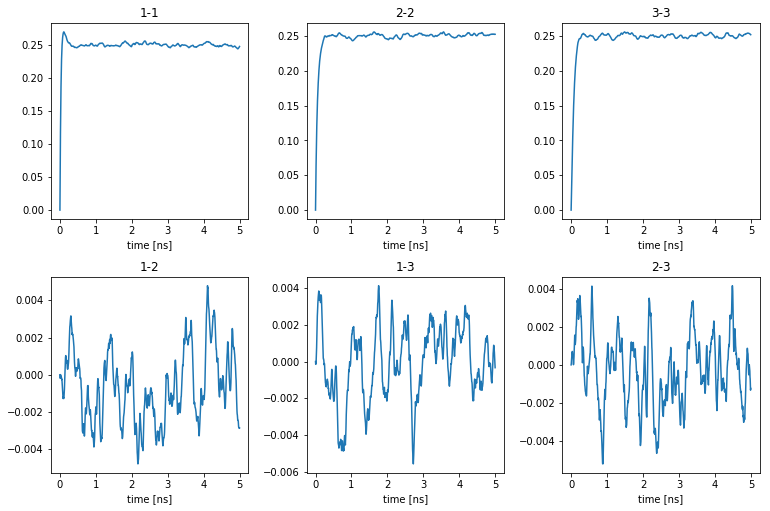

In [9]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time)
cfig.set_all_axes(xlabel='time [ns]')

cfig.tight_layout()

We can also zoom into the interesting region before the correlations are equilibratd at 1 nanosecond. Visible at the top row.

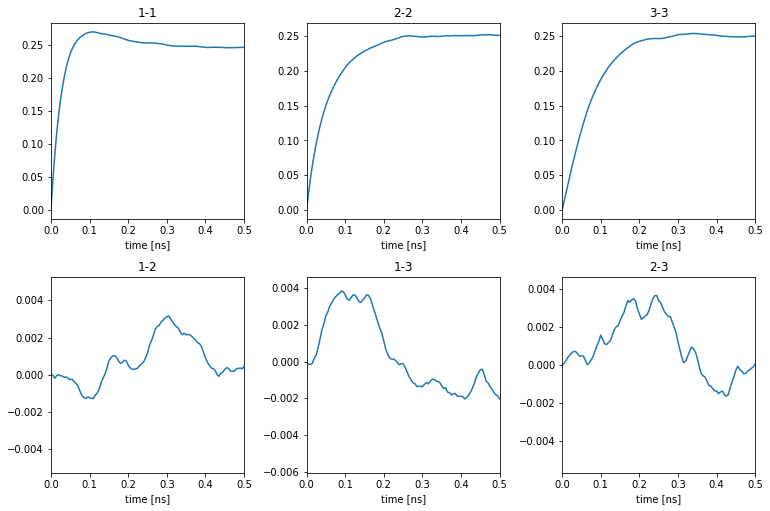

In [10]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time)
cfig.set_all_axes(xlim=(0, .5), xlabel='time [ns]')

cfig.tight_layout()

# Determine Diffusion Coefficient from Quaternion Correlations

Now we can finally fit the diffusion coefficient. Since the correlations only have interesting change that tell us about the diffusion coffiecient until 0.5 nanoseconds we will only fit up to that time.

In [11]:
tmax = .5  # nanoseconds
idx = int(tmax / dt)

res = pydiffusion.rotation.anneal(u3[:,:, :idx], time[:idx], D=[3, 2, 1], eps=0.001)
print("Diffusion coefficients = {}".format(res[0].D))
print("chi 2 = {}".format(res[1]))

Diffusion coefficients = [ 17.20949911   9.4451048    4.48412628]
chi 2 = 0.3295680715312274


This result is already quite close. But the annealing process doesn't always find the gobal minima. Therefore we will run the fit several times and later select the diffusion tensor with the smallest $\chi^2$ value.

In [12]:
res = [pydiffusion.rotation.anneal(u3[:,:, :idx], time[:idx], D=[3, 2, 1], eps=0.001) for _ in range(20)]

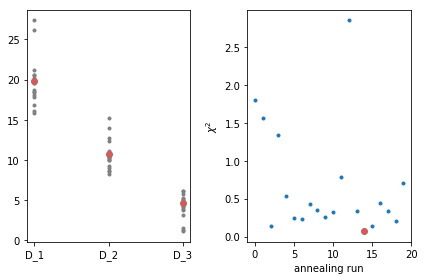

In [13]:
fig, ax = plt.subplots(ncols=2)

for r in res:
    ax[0].plot([1, 2, 3], r[0].D, '.', color='#808080')
    
score = [r[1] for r in res]
ax[1].plot(score, '.')
ax[1].set(ylabel=r'$\chi^2$', xlabel='annealing run')

argmin = np.argmin(score)
ax[0].plot([1, 2, 3], res[argmin][0].D, 'o', color='indianred')
ax[0].set(xticks=[1, 2, 3], xticklabels=['D_1', 'D_2', 'D_3'])
ax[1].plot([argmin,], score[argmin], 'o', color='indianred')

fig.tight_layout()

In [14]:
print("D optimal = {}".format(res[argmin][0].D))
print("chi2 = {}".format(res[argmin][1]))

D optimal = [ 19.84444416  10.80706894   4.70123469]
chi2 = 0.07031698464641396


In the picture you can see the spread of diffusion coefficients and in red the optimal choice that we picked.

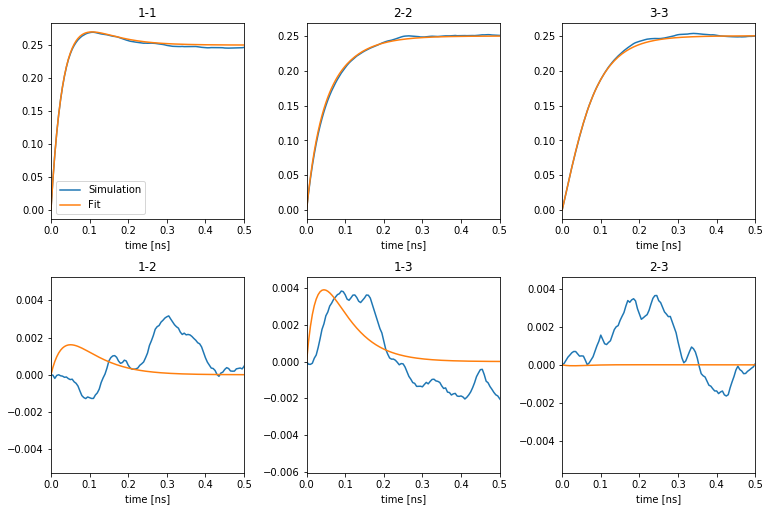

In [16]:
time = np.arange(u3.shape[2]) * dt

cfig = plotting.plot_covariance(u3, time=time, label='Simulation')
plotting.plot_model(res[argmin][0], time, label='Fit', covfig=cfig)
cfig.set_all_axes(xlim=(0, .5), xlabel='time [ns]')
cfig.axes[0, 0].legend()

cfig.tight_layout()